# Machine Learning for Single-Cell Biology
***

Winter Semester 2024/25<br />
Manfred Claassen, Matthias Bruhns, Jan Schleicher
<br />
***

## Assignment 3

### By Ieva Kerseviciute and Arne Gittel

_In the previous assignments, we explored the concept of cell type as a pattern of co- expression of genes. In this assignment, we will focus on identifying genes that are differentially expressed between cell types._

_The expression of individual genes that are known to be specifically expressed in cell types is often used to identify them. These genes are referred to as markers._

_However, to fully understand the functional differences between often closely related cell types, it is important to identify sets of genes that are differentially expressed between cell types._

In [37]:
import numpy as np
import pandas as pd
from umap import UMAP
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import FactorAnalysis
import os
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib

from typing import List, Union, Tuple

sns.set_style("ticks")
%matplotlib inline

In [2]:
DATA_PATH = "data/"
OUTPUT_PATH = "output/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

### Task 1 - Choosing cell type markers (30 points)

_For this task, you have been provided with the following expression dataset and cell type annotations. The dataset was normalized such that each cell had the same total expression. Subsequently, each entry of the normalized expression matrix was transformed like so: log(count+1)._

_Expression data: expression_data_1.txt_

_Cell type labels: celltype_data_1.txt_

__A.__ _Plot a heatmap of mean gene expression per cell type of the following genes: (10 points)_

_CCR7, CD14, IL7R, S100A4, MS4A1, CD8A, FCGR3A, MS4A7, FCGR3A, NKG7, FCER1A, PPBP_

In [3]:
def task1a_get_mean_per_cell_type(expression_df: pd.DataFrame,
                                  cell_type_df: pd.DataFrame,
                                  gene_list: List[str],
                                  cell_type_col: str = "cell_type") -> pd.DataFrame:
    """
    Compute the mean expression per cell type from a single-cell expression matrix.
    :param expression_df: A DataFrame of shape (n_cells, n_genes) containing the expression data.
    :param cell_type_df: A DataFrame of shape (n_cells, n_annotations) containing metadata (including cell type).
    :param gene_list: A list of marker genes for which to compute mean expression.
    :param cell_type_col: The name of the column in cell_type_df that contains cell type annotations.
    :return: A DataFrame of shape (n_cell_types, n_markers) with the mean expression per cell type for the given genes.
    """

    cell_type_means = []

    for cell_type, data in cell_type_df.groupby("cell_type"):
        cell_type_mean = pd.DataFrame([ expression_df.loc[data.index][gene_list].mean() ])
        cell_type_mean.index = [cell_type]
        cell_type_means.append(cell_type_mean)

    cell_type_means = pd.concat(cell_type_means)

    return cell_type_means

In [14]:
def task1a_plot_heatmap(cell_type_means: pd.DataFrame) -> None:
    """
    Plot a heatmap displaying mean expression per cell type.
    :param cell_type_means: A DataFrame of shape (n_cell_types, n_markers) with the mean expression per cell type.
    :return:
    """

    plt.imshow(cell_type_means, cmap = "viridis")
    plt.colorbar()
    plt.title("Mean expression per cell type")
    plt.xlabel("Gene")
    plt.ylabel("Cell type")

    plt.xticks(ticks = range(cell_type_means.shape[1]), labels = cell_type_means.columns, rotation = 90)
    plt.yticks(ticks = range(cell_type_means.shape[0]), labels = cell_type_means.index)

    plt.show()
    
    return None

In [17]:
def task1c_compute_umap(expression_df: pd.DataFrame) -> np.ndarray:
    """
    Compute a UMAP embedding of the expression data.
    :param expression_df: A Dataframe of shape (n_cells, n_genes) containing the expression data.
    :return: An array of shape (n_cells, 2) containing the embedding coordinates.
    """
    embedding = UMAP(random_state = 42, n_jobs = 1).fit_transform(expression_df)
    return embedding

In [ ]:
# Load data
expression_data = pd.read_csv(os.path.join(DATA_PATH, "expression_data_1.txt"), sep="\t", index_col=0)
cell_type_data = pd.read_csv(os.path.join(DATA_PATH, "cell_type_data_1.txt"), sep="\t", index_col=0)

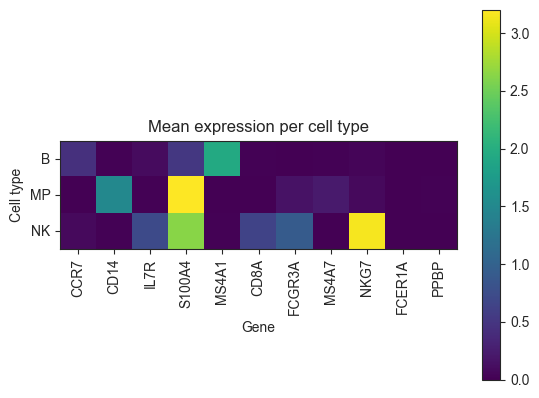

In [15]:
# Get mean expression of marker genes per cell type
marker_genes = ["CCR7", "CD14", "IL7R", "S100A4", "MS4A1", "CD8A", "FCGR3A", "MS4A7", "NKG7", "FCER1A", "PPBP"]
mean_expression = task1a_get_mean_per_cell_type(expression_df=expression_data,
                                                cell_type_df=cell_type_data,
                                                gene_list=marker_genes)

task1a_plot_heatmap(mean_expression)

__B.__ _Based on the heatmap (Task 1A) identify one gene per cell type that could serve as a cell type marker. Explain your reasoning. (10 points)_

Based on the heatmap, the possible cell type markers could be:

- **B**: MS4A1
- **MP**: CD14
- **NK**: NKG7

All of these genes have a high average expression value in their corresponding cell type and close to no expression in other cell types.

__C.__ _Project the expression data into 2D using UMAP and plot each marker on the projection. (10 points)_

In [18]:
# Compute UMAP
umap_coords = task1c_compute_umap(expression_df=expression_data)

/Users/ieva/miniconda3/envs/python-single-cell/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
def plot_embedding_expression(expr_color, embedding, ax = None, legend_title = "", plot_title = ""):
    if ax is None:
        _, ax = plt.subplots(nrows = 1, ncols = 1)
    
    scatter = ax.scatter(
        embedding[:, 0], embedding[:, 1],
        c = expr_color,
        s = 10,
        cmap = "viridis"
    )

    ax.set_xlabel(f"UMAP dimension 1")
    ax.set_ylabel(f"UMAP dimension 2")

    colorbar = plt.colorbar(scatter, ax = ax)
    colorbar.set_label(legend_title)

    ax.set_title(plot_title)

    if ax is None:
        plt.show()

def plot_embedding(categories, embedding, alpha = 1, ax = None, show_legend = False,
                   legend_title = "Cell type", plot_title = ""):
    if ax is None:
        _, ax = plt.subplots(nrows = 1, ncols = 1)
        show_legend = True

    color_palette = matplotlib.colormaps["Paired"]
    colors_map = [color_palette(i) for i in range(len(categories.unique()))]

    for i, category in enumerate(categories.unique()):
        point_idx = np.where(categories == category)

        ax.scatter(
            embedding[point_idx, 0], embedding[point_idx, 1],
            color = colors_map[i],
            alpha = alpha,
            s = 10,
            label = category
        )

    ax.set_xlabel(f"UMAP dimension 1")
    ax.set_ylabel(f"UMAP dimension 2")

    ax.set_title(plot_title)

    if show_legend:
        legend = plt.legend()
        legend.set_title(legend_title)

    if ax is None:
        plt.show()

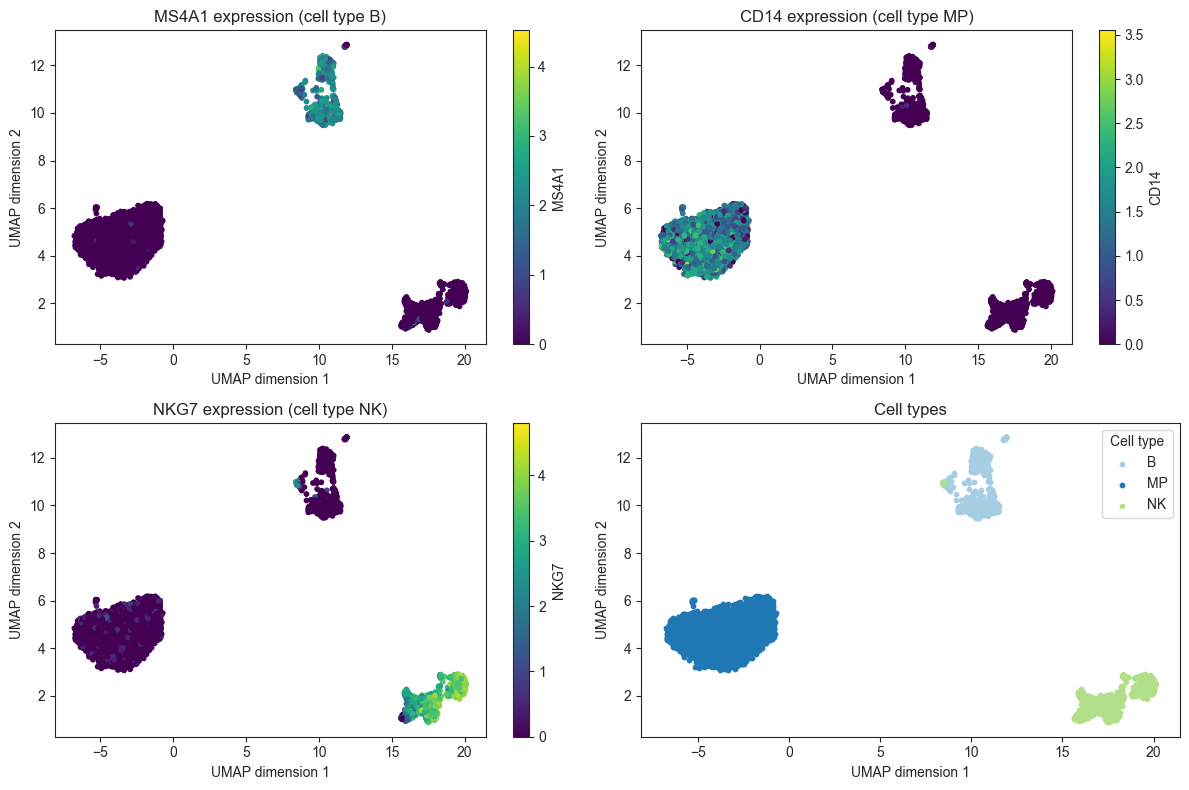

In [57]:
# Plot UMAPs with gene expression

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))

plot_embedding_expression(
    expr_color = expression_data.MS4A1,
    embedding = umap_coords,
    legend_title = "MS4A1",
    ax = axs[0, 0],
    plot_title = "MS4A1 expression (cell type B)"
)

plot_embedding_expression(
    expr_color = expression_data.CD14,
    embedding = umap_coords,
    legend_title = "CD14",
    ax = axs[0, 1],
    plot_title = "CD14 expression (cell type MP)"
)

plot_embedding_expression(
    expr_color = expression_data.NKG7,
    embedding = umap_coords,
    legend_title = "NKG7",
    ax = axs[1, 0],
    plot_title = "NKG7 expression (cell type NK)"
)

plot_embedding(
    categories = cell_type_data.cell_type,
    embedding = umap_coords,
    show_legend = True,
    ax = axs[1, 1],
    plot_title = "Cell types"
)

fig.tight_layout()

In the UMAP plots, different cell types are clearly separated. The cells belonging to each cell type show different gene expression patterns for the cell type markers identified from the heatmap. Namely, each marker gene is expressed mostly by their corresponding cell type.

### Task 2

In [ ]:
def task2a_differential_expression_testing(expression_df: pd.DataFrame,
                                           cell_type_df: pd.DataFrame,
                                           cell_type_col: str = "cell_type") -> pd.DataFrame:
    """
    Perform a differential expression analysis between cell types.
    :param expression_df: A Dataframe of shape (n_cells, n_genes) containing the expression data.
    :param cell_type_df: A DataFrame of shape (n_cells, n_annotations) containing metadata (including cell type).
    :param cell_type_col: The name of the column in cell_type_df that contains cell type annotations.
    :return: A DataFrame with the results of differential expression testing.
    """
    de_results = pd.DataFrame(columns=pd.MultiIndex.from_product([cell_type_df[cell_type_col].unique(),
                                                                  ["p", "logFC", "p_adj"]]),
                              index=expression_df.columns)
    # stats.mannwhitneyu
    #########################
    # INSERT YOUR CODE HERE #
    #########################
    return de_results

In [ ]:
# Perform differential expression analysis
de_genes = task2a_differential_expression_testing(expression_df=expression_data,
                                                  cell_type_df=cell_type_data)
de_genes.to_csv(os.path.join(OUTPUT_PATH, "de_results.tsv"), sep="\t")

**Provide your text answers for Task 2B here**

### Task 3

In [ ]:
def task3a_factor_analysis(expression_df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform factor analysis on the expression data.
    :param expression_df: A Dataframe of shape (n_cells, n_genes) containing the expression data.
    :return: An array with factor activities of shape (n_cells, n_factors) and
    an array with gene loadings of shape (n_factors, n_genes).
    """
    # fa = FactorAnalysis(n_components=3)

    factor_activity = np.zeros((expression_df.shape[0], 3))
    gene_loadings = np.zeros((3, expression_df.shape[1]))

    #########################
    # INSERT YOUR CODE HERE #
    #########################

    return factor_activity, gene_loadings

In [ ]:
# Run factor analysis
factor_activities, gene_loadings = task3a_factor_analysis(expression_df=expression_data)

In [ ]:
# Plot factor activity on UMAP (you can use the function from Task 1C)
#########################
# INSERT YOUR CODE HERE #
#########################

**Provide your text answers for Task 3A here**

In [ ]:
# Export loadings
loadings_df = pd.DataFrame(gene_loadings.T,
                           index=expression_data.columns,
                           columns=[f"factor_{i+1}" for i in range(gene_loadings.shape[0])])
loadings_df.to_csv(os.path.join(OUTPUT_PATH, "fa_gene_loadings.tsv"), sep="\t", header=True, index=True)

**You may perform GSEA with any python tool, but you can also use some online tool if you prefer that. Just make sure to submit the results.**

In [ ]:
# Gene set enrichment analysis
#########################
# INSERT YOUR CODE HERE #
#########################

**Provide your text answers for Task 3B here**